# Crash data assembly notebook
    # I'll import all data, assemble it, and run some preliminary graphing to find out a little bit about it

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import glob
# import openpyxl

## Assemble the dataframe

In [2]:
# Let's get all of our files and concat them together into a mega database
# path = '../data/raw-crash-data/'
# csv_files = glob.glob(path + "/*.xlsx")
# df_list = (pd.read_excel(file) for file in csv_files)
# df = pd.concat(df_list, ignore_index=True)

In [3]:
# df.to_csv('full_crash_database.csv')

## First look at the data

In [4]:
# There are some dates with HUGE numbers of accidents!

# df.DATE.value_counts()

In [5]:
# So I know I'm going to work with this data in different counties, and the first one I want to work with is Denver. So let's create a dataframe just for that.

# df_denver = df[df.COUNTY == 'DENVER']

In [6]:
# df_denver.info()

In [7]:
df_denver = pd.read_csv('df_denver.csv', low_memory=False)

# Remove the original index numbers
df_denver = df_denver.drop('Unnamed: 0', axis=1)

In [8]:
# Let's look at the data a bit more
injury_counts = df_denver.SEVERITY.value_counts()
condition_counts = df_denver.CONDITION.value_counts()
weather_counts = df_denver.WEATHER.value_counts()

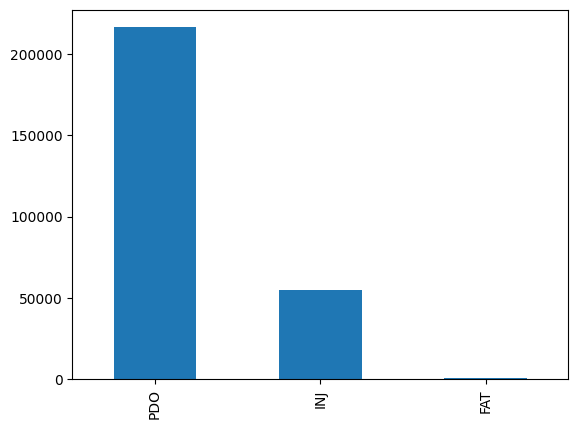

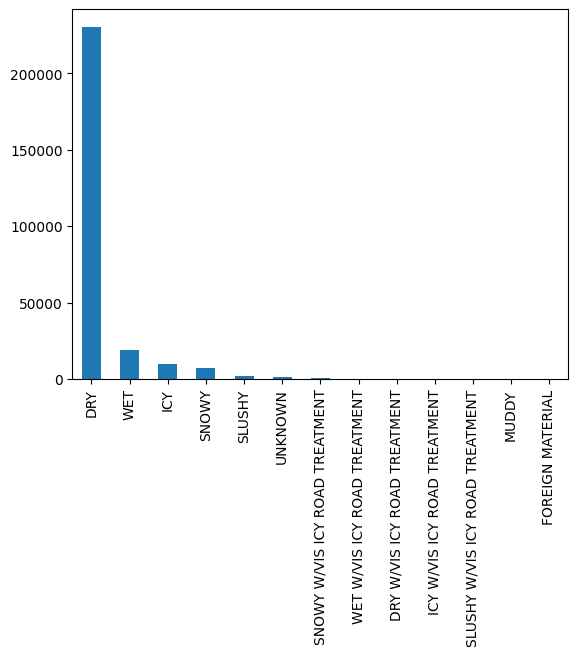

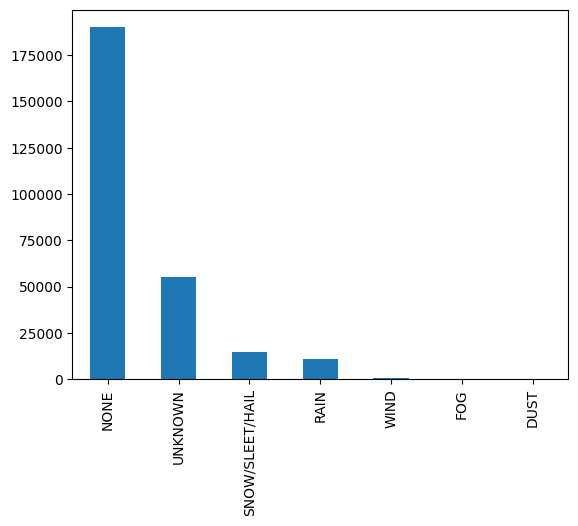

In [9]:
injury_counts.plot.bar()
plt.show()
condition_counts.plot.bar()
plt.show()
weather_counts.plot.bar()
plt.show()

## Let's feature engineer a little, and trim the data to prepare it

In [10]:
# I'll create functions because I want to engineer future datasets the same for other counties

# First I'd like to add more date data to enable better sorting in the future, since I know my final questions will involve number of accidents per day

def add_dates_to_df(passed_df):
    passed_df['YEAR'] = passed_df.DATE.dt.year
    passed_df['MONTH'] = passed_df.DATE.dt.month
    passed_df['DAY'] = passed_df.DATE.dt.day
    passed_df['DAYOFWEEK'] = passed_df.DATE.dt.day_of_week

In [11]:
# add_dates_to_df(df_denver)

In [12]:
df_denver.head()

,SYSTEM,DATE,TIME,SEVERITY,INJLEVEL_1,INJLEVEL_2,INJLEVEL_3,INJLEVEL_4,INJLEVEL_5,AGENCYNAME,...,DRVINJ_1,DRVINJ_2,DRVINJ_3,DUI_1,DUI_2,DUI_3,YEAR,MONTH,DAY,DAYOFWEEK
0,CITY STREET,2007-01-01,0.0,PDO,1,0,0,0,0,DPD,...,NaN,NO INJURY,NaN,N,N,N,2007,1,1,0
1,CITY STREET,2007-01-01,45.0,PDO,1,0,0,0,0,DPD,...,NO INJURY,NaN,NaN,N,N,N,2007,1,1,0
2,CITY STREET,2007-01-01,100.0,PDO,0,0,0,0,0,DPD,...,NaN,NaN,NaN,N,N,N,2007,1,1,0
3,CITY STREET,2007-01-01,100.0,PDO,2,0,0,0,0,DPD,...,NO INJURY,NO INJURY,NaN,N,N,N,2007,1,1,0
4,INTERSTATE,2007-01-01,117.0,PDO,2,0,0,0,0,DPD,...,NO INJURY,NaN,NaN,N,N,N,2007,1,1,0


In [13]:
# Now let's remove a few columns I know I don't need. I can remove the city and county because I know all of these are Denver C&C, the lat/long won't be necessary for the same reason RTE, SEC, and MP aren't - I'm interested in stats as a whole and not in a particular crash.

def clean_columns(passed_df):
    passed_df = passed_df.drop(['LATITUDE', 'LONGITUDE', 'CITY', 'COUNTY', 'RTE', 'SEC', 'MP'], axis=1, inplace=True)

In [14]:
# clean_columns(df_denver)

In [15]:
# df_denver.to_csv('df_denver.csv')
df_denver.head()

,SYSTEM,DATE,TIME,SEVERITY,INJLEVEL_1,INJLEVEL_2,INJLEVEL_3,INJLEVEL_4,INJLEVEL_5,AGENCYNAME,...,DRVINJ_1,DRVINJ_2,DRVINJ_3,DUI_1,DUI_2,DUI_3,YEAR,MONTH,DAY,DAYOFWEEK
0,CITY STREET,2007-01-01,0.0,PDO,1,0,0,0,0,DPD,...,NaN,NO INJURY,NaN,N,N,N,2007,1,1,0
1,CITY STREET,2007-01-01,45.0,PDO,1,0,0,0,0,DPD,...,NO INJURY,NaN,NaN,N,N,N,2007,1,1,0
2,CITY STREET,2007-01-01,100.0,PDO,0,0,0,0,0,DPD,...,NaN,NaN,NaN,N,N,N,2007,1,1,0
3,CITY STREET,2007-01-01,100.0,PDO,2,0,0,0,0,DPD,...,NO INJURY,NO INJURY,NaN,N,N,N,2007,1,1,0
4,INTERSTATE,2007-01-01,117.0,PDO,2,0,0,0,0,DPD,...,NO INJURY,NaN,NaN,N,N,N,2007,1,1,0


In [16]:
# Now let's use some info from the data dictionary to spruce up our columns a little:

# Injlevel_1	Persons Not Injured (O)
# Injlevel_2	Persons w/ Possible Injury (C)
# Injlevel_3	Persons w/ Suspected Minor Injury (B)
# Injlevel_4	Persons w/ Suspected Serious Injury (A)
# Injlevel_5	Persons Killed (K)

# We're going to want to assign weightings a bit. The data should reflect that a death is a worse outcome than no one being injured.

# We're using a weighting where x = injury level, y = number of injuries. Weighting will be y * (x * sqrt(x)). This will help give more severe injuries a higher weighting. They'll still be lower in the gross sense, since there are fewer of them, but this will balance things a little.

# Even injury level 1, with no injuries, should be counted. This is because it had the POTENTIAL for injuries, regardless of the fact they didn't happen.

def injury_weightings(passed_df):
    injury_sums = {'1': passed_df.INJLEVEL_1.sum(), '2': passed_df.INJLEVEL_2.sum(), '3': passed_df.INJLEVEL_3.sum(), '4': passed_df.INJLEVEL_4.sum(), '5': passed_df.INJLEVEL_5.sum()}
    returned_df_name = pd.DataFrame(data=injury_sums, index=[0] )
    returned_df_name = returned_df_name.T
    injury_multiplier = []
    for i in range(1, 6):
        mult = i * np.sqrt(i)
        injury_multiplier.append(round(mult, 2))
    returned_df_name.rename(columns={0: 'SUMS'}, inplace=True)
    returned_df_name['MULTIPLIER'] = injury_multiplier
    injury_post_weighting = returned_df_name['SUMS'] * returned_df_name['MULTIPLIER']
    returned_df_name['WEIGHTED'] = round(injury_post_weighting)

    return returned_df_name

In [17]:
df_denver_injury_counts = injury_weightings(df_denver)

In [18]:
df_denver_injury_counts

,SUMS,MULTIPLIER,WEIGHTED
1,524090,1.00,524090.0
2,44287,2.83,125332.0
3,21167,5.20,110068.0
4,7462,8.00,59696.0
5,639,11.18,7144.0


In [19]:
# So in order to apply our weightings to the dataset we're going to need to add the total weighted value to each row, and then use those weighted values summed for each day to determine how 'bad' a day is.


def add_injury_multipliers(passed_df):
    injury_multipliers = {'INJLEVEL_1': 1.00,
                          'INJLEVEL_2': 2.83,
                          'INJLEVEL_3': 5.20,
                          'INJLEVEL_4': 8.00,
                          'INJLEVEL_5': 11.18,
                          }
    # injury_multipliers = {'INJLEVEL_1': 1,
    #                       'INJLEVEL_2': 8,
    #                       'INJLEVEL_3': 27,
    #                       'INJLEVEL_4': 64,
    #                       'INJLEVEL_5': 125,
    #                       }
    injury_columns = ['INJLEVEL_1', 'INJLEVEL_2', 'INJLEVEL_3', 'INJLEVEL_4', 'INJLEVEL_5']
    for row in passed_df.index:
        i = 0
        temp_list = []
        for n in range(0, 5):
            num_of_injuries = passed_df.at[row, injury_columns[i]]
            temp_list.append(num_of_injuries * injury_multipliers[injury_columns[i]])
            i += 1
        passed_df.at[row, 'ACCIDENT_SEVERITY'] = np.sum(np.asarray(temp_list))


In [20]:
add_injury_multipliers(df_denver)

In [21]:
# Let's compile our severities for each day into a dataframe. We also need day of week, and number of accidents total.
def compile_severities(passed_df):

    date_list = []
    accident_severity_dict = {}
    number_of_accidents_dict = {}

    for row in passed_df.index:
        current_date = passed_df.at[row, 'DATE']
        accident_severity = passed_df.at[row, 'ACCIDENT_SEVERITY']
        day_of_week = passed_df.at[row, 'DAYOFWEEK']
        if current_date in date_list:
            accident_severity_dict[current_date] = accident_severity_dict[current_date] + accident_severity
            number_of_accidents_dict[current_date] += 1
        elif current_date not in date_list:
            date_list.append(current_date)
            number_of_accidents_dict[current_date] = 1
            accident_severity_dict[current_date] = accident_severity

    returned_df = pd.DataFrame(date_list, columns=['DATE'])
    returned_df['DATE'] = pd.to_datetime(returned_df['DATE'])
    returned_df['NUMBER_OF_ACCIDENTS'] = number_of_accidents_dict.values()
    returned_df['TOTAL_SEVERITY'] = accident_severity_dict.values()
    returned_df['YEAR'] = returned_df.DATE.dt.year
    returned_df['MONTH'] = returned_df.DATE.dt.month
    returned_df['DAY'] = returned_df.DATE.dt.day
    returned_df['DAYOFWEEK'] = returned_df.DATE.dt.day_of_week
    returned_df['TOTAL_SEVERITY'] = round(returned_df['TOTAL_SEVERITY'], 0)
    returned_df['TOTAL_SEVERITY'] = returned_df['TOTAL_SEVERITY'].astype('int64')

    return returned_df

In [22]:
df_denver_severity_by_dates = compile_severities(df_denver)


In [23]:
df_denver_severity_by_dates.to_csv('df_denver_severity_by_dates.csv', index=False)

In [24]:
# df = df_denver_severity_by_dates
df = pd.read_csv('df_denver_severity_by_dates.csv')

In [25]:
# Let's check out our new data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DATE                 5113 non-null   object
 1   NUMBER_OF_ACCIDENTS  5113 non-null   int64 
 2   TOTAL_SEVERITY       5113 non-null   int64 
 3   YEAR                 5113 non-null   int64 
 4   MONTH                5113 non-null   int64 
 5   DAY                  5113 non-null   int64 
 6   DAYOFWEEK            5113 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 279.7+ KB


<AxesSubplot: xlabel='NUMBER_OF_ACCIDENTS', ylabel='TOTAL_SEVERITY'>

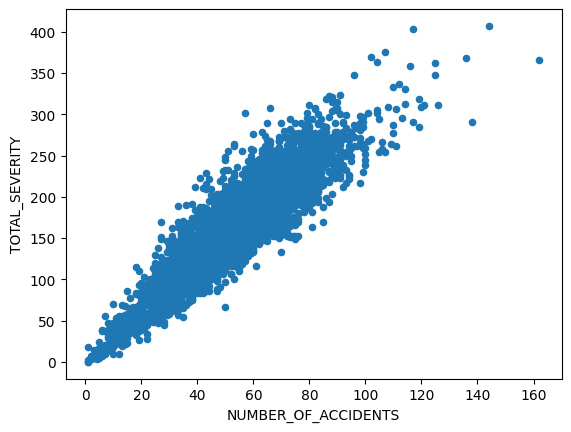

In [26]:
df.plot.scatter(x='NUMBER_OF_ACCIDENTS', y='TOTAL_SEVERITY')

<AxesSubplot: xlabel='MONTH', ylabel='TOTAL_SEVERITY'>

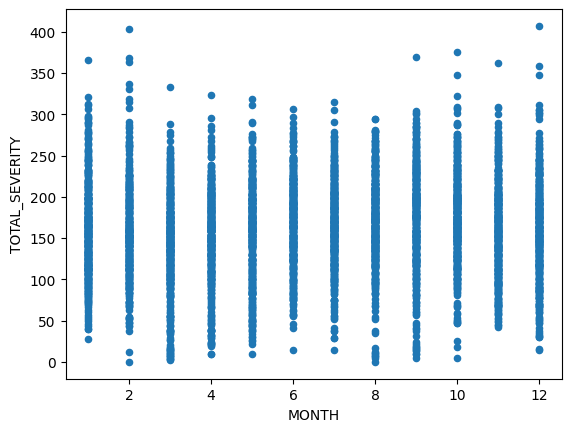

In [27]:
# The winter months definitely have higher total severity dots
df.plot.scatter(x='MONTH', y='TOTAL_SEVERITY')

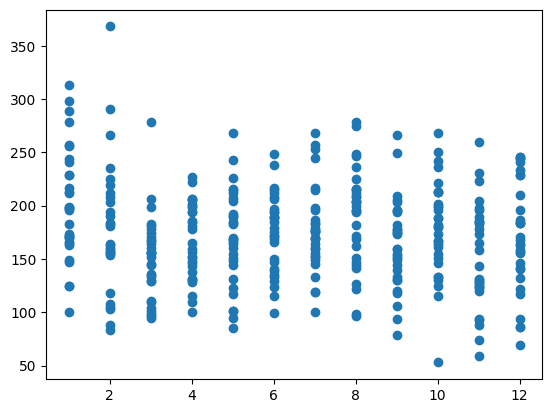

In [28]:
fig, ax = plt.subplots()
ax.scatter(df['MONTH'][:365], df['TOTAL_SEVERITY'][:365])


## Let's take a look at the top 100 and 500 and get some charts and exports

In [29]:
top_100_severity = df_denver_severity_by_dates.nlargest(100, 'TOTAL_SEVERITY')


<AxesSubplot: xlabel='MONTH', ylabel='TOTAL_SEVERITY'>

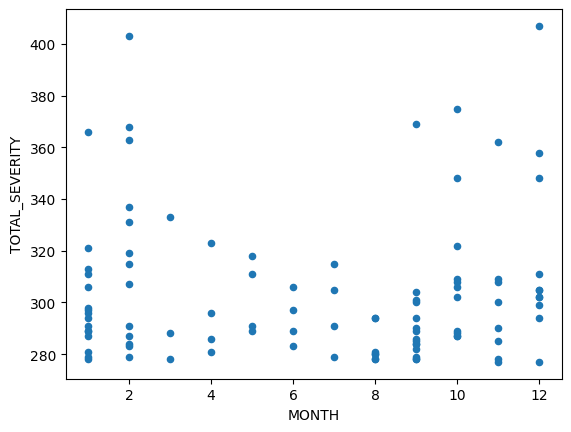

In [30]:
top_100_severity.plot.scatter(x='MONTH', y='TOTAL_SEVERITY')


In [31]:
top_100_by_month = top_100_severity['MONTH'].value_counts()

<AxesSubplot: >

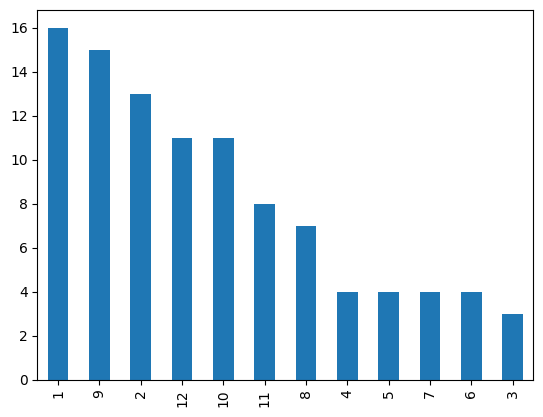

In [32]:
top_100_by_month.plot.bar()

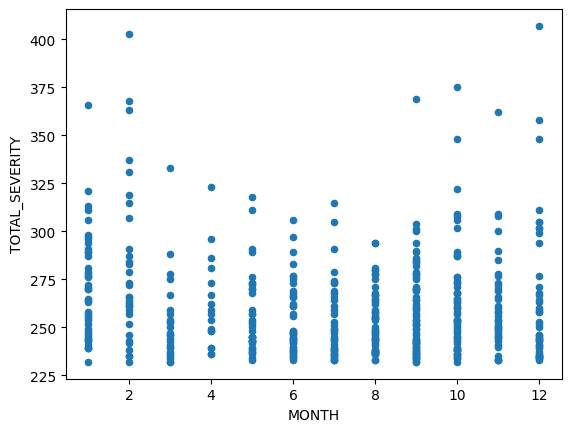

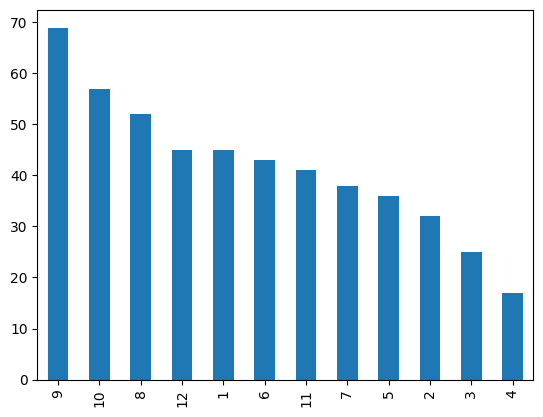

In [33]:
top_500_severity = df_denver_severity_by_dates.nlargest(500, 'TOTAL_SEVERITY')
top_500_by_month = top_500_severity['MONTH'].value_counts()
top_500_severity.plot.scatter(x='MONTH', y='TOTAL_SEVERITY')
plt.show()
top_500_by_month.plot.bar()
plt.show()

In [34]:
# Interestingly we see the data spread out quite a bit more on the top 500 to include non-winter months. Cross-referencing each day's weather will prove exciting.

In [35]:
# Let's go back to the top 100 and try to sum our severities and distribute those by month.
def sum_severities_by_month(passed_df):
    month_dict = {}
    for row in passed_df.index:
        total_severity = passed_df.at[row, 'TOTAL_SEVERITY']
        month = passed_df.at[row, 'MONTH']
        if month not in month_dict.keys():
            month_dict[month] = total_severity
        elif month in month_dict.keys():
            month_dict[month] = month_dict[month] + total_severity
    returned_df = pd.DataFrame(data=month_dict.values(), index=month_dict.keys(), columns=['SEVERITY'])

    return returned_df

AttributeError: module 'pandas.plotting' has no attribute 'bar'

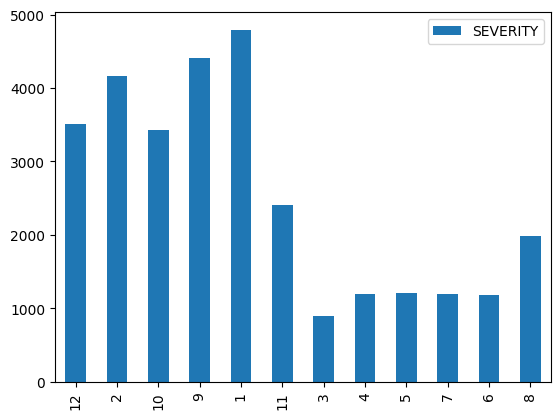

In [36]:
top_100_aggregated_monthly_severity = sum_severities_by_month(top_100_severity)
top_100_aggregated_monthly_severity.plot.bar()
pd.plotting.bar()

In [ ]:
top_500_aggregated_monthly_severity = sum_severities_by_month(top_500_severity)
top_500_aggregated_monthly_severity.plot.bar()

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharex='all')
fig.suptitle('Top 100 Most Severe Accidents in Denver (2007-2020)', fontsize=20)
ax1.bar(x=top_100_aggregated_monthly_severity.index, height=top_100_aggregated_monthly_severity['SEVERITY'])
ax1.axhline(top_100_aggregated_monthly_severity['SEVERITY'].median(), c='red', label='Median of Severity')
ax2.scatter(x=top_100_severity.MONTH, y=top_100_severity['TOTAL_SEVERITY'])
ax1.set_title('Total Severity by Month')
ax2.set_title('Occurrences by Month')
x_axis = np.arange(1, 13, 1)
ax1.legend()
plt.xticks(x_axis)
plt.show()

In [ ]:
top_100_severity.to_csv('top_100_severity.csv', index=False)
top_500_severity.to_csv('top_500_severity.csv', index=False)

## Scaling

In [ ]:
df['TOTAL_SEVERITY'].plot.hist()

In [ ]:
# Lets min-max scale that severity column to help the model out.

In [ ]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [ ]:
df['TOTAL_SEVERITY'] = minmax_scale(df['TOTAL_SEVERITY'])

# scaler = StandardScaler()
# transformer = ColumnTransformer(
#                 [('standard_scaler', scaler, ['TOTAL_SEVERITY'])],
#                 remainder='drop')
# df_t = transformer.fit_transform(df)

In [ ]:
df['TOTAL_SEVERITY'].plot.hist(bins=20)

In [ ]:
# Looks like we have a nice distribution curve, and now with it scaled a bit hopefully the model has a better time with it. I don't care for the outliers on the right, I might try different forms of scaling later on as I progress in this dataset.

In [ ]:
df.to_csv('crashes_cleaned.csv', index=False)